<a href="https://colab.research.google.com/github/divyanshusharma1709/DogBB/blob/master/dogCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import cv2
from imutils import paths
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import numpy as np
#!pip install git+git://github.com/raghakot/keras-vis.git --upgrade --no-deps
# Important Libraries imported

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
!tar -xvzf /content/gdrive/My\ Drive/dogDataset.tar.gz
!tar -xJf /content/gdrive/My\ Drive/labels_norm_pickle.tar.xz

# dataset unzipped and saved at dogDataset

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
dogDataset/
dogDataset/Images/
dogDataset/Images/522.jpg
dogDataset/Images/1035.jpg
dogDataset/Images/1270.jpg
dogDataset/Images/910.jpg
dogDataset/Images/236.jpg
dogDataset/Images/717.jpg
dogDataset/Images/442.jpg
dogDataset/Images/186.jpg
dogDataset/Images/1495.jpg
dogDataset/Images/1106.jpg
dogDataset/Images/933.jpg
dogDataset/Images/1335.jpg
dogDataset/Images/1287.jpg
dogDataset/Images/1377.jpg
dogDataset/Images/401.jpg
dogDataset/Images/1367.jpg
dogDatas

dogDataset/Images/1228.jpg


In [0]:
imagePaths = list(sorted(paths.list_images("dogDataset/Images")))
del[imagePaths[256]] #1228.xml doesn't have co-ordinates. Faulty label. Removing image and annotation from dataset
annPaths = list(sorted(os.listdir("dogDataset/Annotation/")))
path = "dogDataset/Annotation/"
annPaths = [path + annPaths[i] for i in range(len(annPaths))]
del[annPaths[256]]

#import pickle
#labels_norm = pickle.load(open('labels_norm_pickle.bin', 'rb'))
# Extracting image ans annotation paths

In [0]:
print(imagePaths)

['dogDataset/Images/0.jpg', 'dogDataset/Images/1.jpg', 'dogDataset/Images/10.jpg', 'dogDataset/Images/100.jpg', 'dogDataset/Images/1000.jpg', 'dogDataset/Images/1001.jpg', 'dogDataset/Images/1002.jpg', 'dogDataset/Images/1003.jpg', 'dogDataset/Images/1004.jpg', 'dogDataset/Images/1005.jpg', 'dogDataset/Images/1006.jpg', 'dogDataset/Images/1007.jpg', 'dogDataset/Images/1008.jpg', 'dogDataset/Images/1009.jpg', 'dogDataset/Images/101.jpg', 'dogDataset/Images/1010.jpg', 'dogDataset/Images/1011.jpg', 'dogDataset/Images/1012.jpg', 'dogDataset/Images/1013.jpg', 'dogDataset/Images/1014.jpg', 'dogDataset/Images/1015.jpg', 'dogDataset/Images/1016.jpg', 'dogDataset/Images/1017.jpg', 'dogDataset/Images/1018.jpg', 'dogDataset/Images/1019.jpg', 'dogDataset/Images/102.jpg', 'dogDataset/Images/1020.jpg', 'dogDataset/Images/1021.jpg', 'dogDataset/Images/1022.jpg', 'dogDataset/Images/1023.jpg', 'dogDataset/Images/1024.jpg', 'dogDataset/Images/1025.jpg', 'dogDataset/Images/1026.jpg', 'dogDataset/Images/1

In [0]:
#Check if features and labels correspond to each other
for i in range(len(imagePaths)):
  im_num = (imagePaths[i].split('/')[-1]).split('.')[0]
  lab_num = (annPaths[i].split('/')[-1]).split('.')[0]  
  if im_num != lab_num:
    print("Not Equal")
print("Features and Labels Match")

Features and Labels Match


In [0]:
N = 4
img_dim = 256
smooth = 0.9

In [0]:
from bs4 import BeautifulSoup as Soup
def generateLabel(img_path, ann_path):
    soup = Soup(open(ann_path),'xml')
    labels_old = []
    image = []
    labels_old.append(int(soup.find('bndbox').find("xmin").text))
    labels_old.append(int(soup.find('bndbox').find("ymin").text))
    labels_old.append(int(soup.find('bndbox').find("xmax").text))
    labels_old.append(int(soup.find('bndbox').find("ymax").text))
    # print(labels_old)
    #Normalizing this (w.r.t image dim will get rid of dim_dependence!
    image = np.array(load_img(img_path))
    #Labels_Norm = [xmin, ymin, xmax, ymax]
    labels_norm = [labels_old[0]/image.shape[1], labels_old[1]/image.shape[0], labels_old[2]/image.shape[1], labels_old[3]/image.shape[0]]
    return np.array(labels_norm)
def convertLabelDim(labels_norm, img_dim, N, i, j, smooth = 0.9):
  #bx = (real_x_mp - (x_wanted*grid_size))/grid_size
  #by = (real_y_mp - (y_wanted*grid_size))/grid_size
  #x_wanted = real_x_mp % n_partitions
  #y_wanted = real_y_mp % n_partitions
  #w = w_real/grid_size
  #b = h_real/grid_size
  grid_size = img_dim/N
  labels = [labels_norm[i] * img_dim for i in range(len(labels_norm))]
  labels = list(map(int, labels))
  real_x_mp = (labels[2] + labels[0])/2
  real_y_mp = (labels[3] + labels[1])/2
  # print(real_x_mp, real_y_mp)
  # print(grid_size)
  x_wanted =  int(real_x_mp / grid_size)
  # print(x_wanted)
  y_wanted = int(real_y_mp / grid_size)
  # print(y_wanted)
  bx = ((real_x_mp - (x_wanted*grid_size))/float(grid_size))
  by = (real_y_mp - (y_wanted*grid_size))/float(grid_size)
  h = (labels[3] - labels[1])/float(grid_size)
  w = (labels[2] - labels[0])/float(grid_size)
  if (i == x_wanted and j == y_wanted):
    prob = 1.0 * smooth
  else:
    prob = 0
  label = [prob, bx, by, w, h]
  return label


def plot(image, xmp, ymp, bw, bh):
    cv2.rectangle(image, (int(xmp - bw/2), int(ymp - bh/2)), (int(bw/2 + xmp), int(bh/2 + ymp)), (255, 0, 0), 2) #Top left

In [0]:
##################### Test Label loader and converter #############################
img = imagePaths[0]
ann = annPaths[0]
print(img, ann)
norm_l = generateLabel(img, ann)

dogDataset/Images/0.jpg dogDataset/Annotation/0.xml
[293, 200, 406, 261]


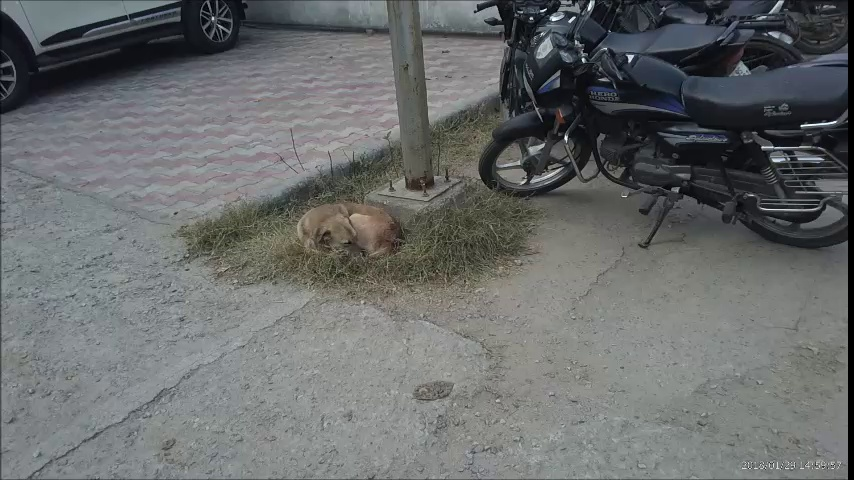

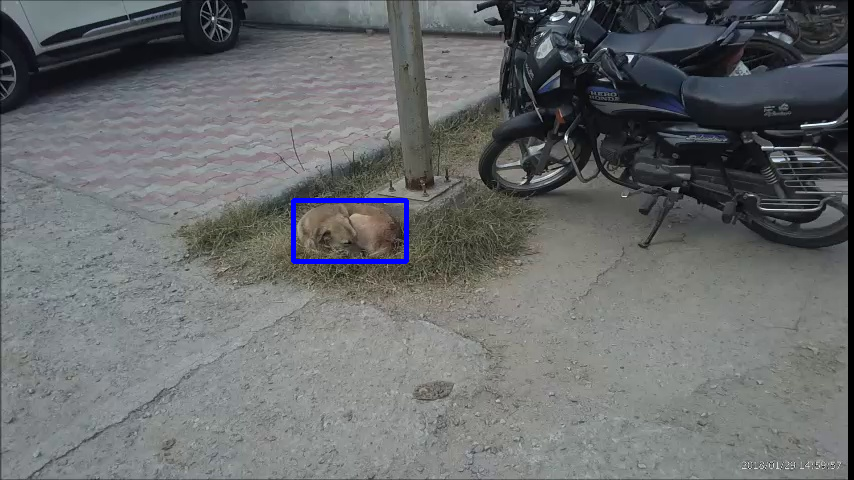

In [0]:
from google.colab.patches import cv2_imshow
im = cv2.imread(img, cv2.COLOR_BGR2RGB)
cv2_imshow(im)
cv2.rectangle(im, (293, 200), (406, 261), (255, 0, 0), 3)
cv2_imshow(im)
#The labels extracted are correct

[87, 106, 121, 139]


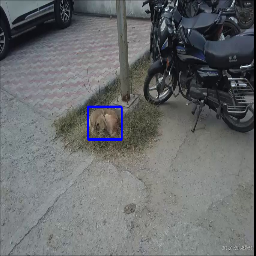

In [0]:
# (0, 0) is at top left
img_res = cv2.resize(im, (256, 256))
lab_new = list(map(int, [x * 256 for x in norm_l]))
print(lab_new)
cv2_imshow(cv2.rectangle(img_res, (lab_new[0], lab_new[1]), (lab_new[2], lab_new[3]), (255, 0 , 0)))
#Normalized Labels correctly working after reshaping image

0
64
128
192
0
64
128
192


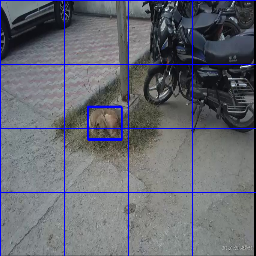

In [0]:
#Draw Grid on Image
for i in range(0, 256, 64):
  print(i)
  cv2.line(img_res, (i, 0), (i, 256), (256, 0, 0), 1)
for j in range(0, 256, 64):
  print(j)
  cv2.line(img_res, (0, j), (256, j), (256, 0, 0), 1)
cv2_imshow(img_res)
#This means that grid cell assigned is (2, 2) (Starting from 1)
#This means that label wanted for cell (2, 2) is: [1, 0.625, 0.914, 0.53125, 0.515625]
#bx = (real_x_mp - (x_wanted*grid_size))/grid_size
#by = (real_y_mp - (y_wanted*grid_size))/grid_size
#x_wanted = real_x_mp % n_partitions
#y_wanted = real_y_mp % n_partitions
#w = w_real/grid_size
#b = h_real/grid_size

In [59]:
lab = []
for i in range(N):
  for j in range(N):
    lab.append(convertLabelDim(norm_l, 256, N, i, j))
print(np.shape(lab))
#This means that label wanted for cell (2, 2) is: [1, 0.625, 0.914, 0.53125, 0.515625]

104.0 122.5
64.0
1
1
104.0 122.5
64.0
1
1
104.0 122.5
64.0
1
1
104.0 122.5
64.0
1
1
104.0 122.5
64.0
1
1
104.0 122.5
64.0
1
1
104.0 122.5
64.0
1
1
104.0 122.5
64.0
1
1
104.0 122.5
64.0
1
1
104.0 122.5
64.0
1
1
104.0 122.5
64.0
1
1
104.0 122.5
64.0
1
1
104.0 122.5
64.0
1
1
104.0 122.5
64.0
1
1
104.0 122.5
64.0
1
1
104.0 122.5
64.0
1
1
(16, 5)


In [0]:
########################################################### GENERATE LABELS #######################################################################

In [62]:
labels_norm = []
ctr = 0
for i in range(len(imagePaths)):
  labels_norm.append(generateLabel(imagePaths[i], annPaths[i]))
  ctr +=1
  print(ctr)
print("Shape of BB without probability: ")
print(np.shape(labels_norm))
labels_norm = np.array(labels_norm)
lab = []
for x in range(labels_norm.shape[0]):
  for i in range(N):
    for j in range(N):
      lab.append(convertLabelDim(labels_norm[x], img_dim, N, i, j))
print(np.shape(lab))
lab = np.reshape(lab, (1497, N, N, 5))
print(np.shape(lab))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [63]:
print(lab[0])

[[[0.        0.625     0.9140625 0.53125   0.515625 ]
  [0.        0.625     0.9140625 0.53125   0.515625 ]
  [0.        0.625     0.9140625 0.53125   0.515625 ]
  [0.        0.625     0.9140625 0.53125   0.515625 ]]

 [[0.        0.625     0.9140625 0.53125   0.515625 ]
  [0.9       0.625     0.9140625 0.53125   0.515625 ]
  [0.        0.625     0.9140625 0.53125   0.515625 ]
  [0.        0.625     0.9140625 0.53125   0.515625 ]]

 [[0.        0.625     0.9140625 0.53125   0.515625 ]
  [0.        0.625     0.9140625 0.53125   0.515625 ]
  [0.        0.625     0.9140625 0.53125   0.515625 ]
  [0.        0.625     0.9140625 0.53125   0.515625 ]]

 [[0.        0.625     0.9140625 0.53125   0.515625 ]
  [0.        0.625     0.9140625 0.53125   0.515625 ]
  [0.        0.625     0.9140625 0.53125   0.515625 ]
  [0.        0.625     0.9140625 0.53125   0.515625 ]]]


In [0]:
# from matplotlib import pyplot as plt
features = []
for i in range(len(imagePaths)):
  image = load_img(imagePaths[i], target_size = (img_dim, img_dim))
  image = img_to_array(image)
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  features.append(image)
  print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [0]:
# #Create flipped features
# features_flip = []
# for i in range(len(imagePaths)):
#   image = load_img(imagePaths[i], target_size = (img_dim, img_dim))
#   image = img_to_array(image)
#   image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
#   image = cv2.flip(image, 1)
#   features_flip.append(image)
#   print(i)

In [0]:
features = np.array(features)
# features_flip = np.array(features_flip)

In [0]:
# #Create flipped Labels:
# labels_flip = lab.copy()
# for i in range(lab.shape[0]):
#   for j in range(lab.shape[1]):
#     for k in range(lab.shape[2]):
#       d = N/2 - j
#       if lab[i][j][k][0] == 1:
#         if (int(d)) > 0:
#           x = N/2 + j
#           labels_flip[i][j][k][0] = 0
#           labels_flip[i][x][k][0] = 1 * smooth
#         elif (int(d)) < 0:
#           labels_flip[i][j][k][0] = 0
#           labels_flip[i][i-n+2*d][k][0] = 1 * smooth                 

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit_transform((features.flatten()).reshape(-1, 1))
features = np.reshape(features, (-1, img_dim, img_dim, 3))
# scaler.fit_transform((features_flip.flatten()).reshape(-1, 1))
# features_flip = np.reshape(features_flip, (-1, img_dim, img_dim, 3))

In [0]:
# features = np.vstack((features, features_flip))
# lab = np.vstack((lab, labels_flip))

In [0]:
print(lab.shape)

(1497, 16, 16, 5)


In [0]:
print(features.shape)

(1497, 32, 32, 3)


In [0]:
features.shape[0] == lab.shape[0]

True

In [0]:
# from sklearn.model_selection import train_test_split
# features_train, features_test, labels_train, labels_test = train_test_split(features, labels, random_state = 42, shuffle = True, test_size = 0.30)

In [0]:
import tensorflow as tf
import keras.backend as K
 
def IOU(box1, box2):
  (xmi1, ymi1, xma1, yma1) = genNot1(box1[0],box1[1],box1[2], box1[3])
  (xmi2, ymi2, xma2, yma2) = genNot1(box2[0],box2[1],box2[2], box2[3])
  dx = min(xma1, xma2) - max(xmi1, xmi2)
  dy = min(yma1, yma2) - max(ymi1, ymi2)
  if dx >= 0 and dy >= 0:
    area_inter =  dx*dy
  else:
    area_inter = 0
  area_b1 = (abs(xma1 - xmi1)) * (abs(yma1 - ymi1))
  area_b2 = (abs(xma2 - xmi2)) * (abs(yma2 - ymi2))
  area_union = (area_b1 + area_b2 - area_inter)
  try:
    iou = (area_inter)/float(area_union)
  except ZeroDivisionError:
    return 0
  return np.float32(iou)

def MeanIOU(y_pred, y_true):
  ctr = 0
  ious = []
  s = y_pred.shape
  for i in range(s[0]):
    for j in range(s[1]):
      for k in range(s[2]):
        b1 = y_pred[i][j][k][0:]
        b2 = y_true[i][j][k][0:]
        ious.append(IOU(b1, b2))
        ctr += 1
  return np.float32(sum(ious)/(ctr))

In [0]:
###################### TESTING mAP #######################################
def mAP(y_true, y_pred):
  Ithresh = 0.4
  pr_ls = []
  rec = []
  final_dict = {}
  cthresh = 0.3
  for i in range(y_pred.shape[0]):  #For each image
    tp = 0
    fp = 0
    fn = 0
    N = 0
    for j in range(y_pred.shape[1]):
      for k in range(y_pred.shape[2]):
        if (y_pred[i][j][k][0] > cthresh) and (IOU(y_true[i][j][k][1:], y_pred[i][j][k][1:]) > Ithresh):
          N += 1  
        elif (y_pred[i][j][k][0] < cthresh) and (IOU(y_true[i][j][k], y_pred[i][j][k]) > Ithresh):
          fn += 1
    #We have N now, so:
    if N == 0:
      fp += 1
    elif N == 1:
      tp += 1
    elif N > 1:
      tp += 1
      fp += (N - 1)
    prec = tp/ float(tp + fp)
    if tp == 0 and (fp > 0 or fn > 0):
      recall = 0
    elif tp == 0 and fp == 0 and fn == 0:
      recall = 1
    else:
      recall = tp/ float(tp + fn)
    pr_ls.append([prec, recall])
    rec.append(recall)
  rec_set = set(rec)
  for recall in rec_set:
    pr = 0
    for i in range(len(pr_ls)):
      if (pr_ls[i][0] > pr) and (recall == pr_ls[i][1]):
        final_dict[recall] = pr
      else:
        final_dict[recall] = 0
  AP = sum(final_dict.values())/float(len(final_dict))
  return np.float32(AP)

In [0]:
def mAP_metric(y_true, y_pred):
  AP = tf.py_func(mAP, [y_true, y_pred], tf.float32)
  return AP
def IoU_metric(y_true, y_pred):
  m_iou = tf.numpy_function(MeanIOU, [y_true, y_pred], tf.float32)
  return m_iou

In [0]:
def ls(y_true, y_pred):
  err = 0
  w_bb = 5
  p_err = y_true[..., 0] - y_pred[..., 0]
  x_err = y_true[..., 1] - y_pred[..., 1]
  y_err = y_true[..., 2] - y_pred[..., 2]
  bx_err = (K.sqrt(y_true[..., 3]) - K.sqrt(y_pred[..., 3]))
  by_err = (K.sqrt(y_true[..., 4]) - K.sqrt(y_pred[..., 4]))
  #Total Error
  err = K.square(p_err) + w_bb * (K.square(x_err) + K.square(y_err) + K.square(bx_err) + K.square(by_err))
  return err

In [0]:
def genNot1(x, y, bx, by, img_d = img_dim):
  #Return co-ordinates of Bounding Box in clockwise order
  bx *= img_d
  by *= img_d
  xmin = (x - bx/2)
  ymin = (y - by/2)
  xmax = (x + bx/2)
  ymax = (y + by/2)
  return (xmin, ymin, xmax, ymax)

In [0]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
# Install
! npm install -g localtunnel

# Tunnel port 6006 (TensorBoard assumed running)
get_ipython().system_raw('lt --port 6006 >> url.txt 2>&1 &')

# Get url
! cat url.txt

/tools/node/bin/lt -> /tools/node/lib/node_modules/localtunnel/bin/lt.js
+ localtunnel@2.0.0
added 35 packages from 21 contributors in 2.246s
your url is: https://lucky-walrus-88.localtunnel.me


In [0]:
# from keras.callbacks import ModelCheckpoint
# filepath="/weights-improvement_new -{epoch:02d}-{val_IoU_metric:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_IoU_metric', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]

In [0]:
from keras.layers import Dense, Conv2D, Dropout, Dense, BatchNormalization, MaxPool2D, LeakyReLU
from keras.models import Sequential
from keras.optimizers import RMSprop, SGD, Adam, Nadam

In [0]:
import keras.backend as K
K.clear_session()
model = Sequential()
model.add(Conv2D(5, 3, strides = 2, input_shape = (32, 32, 3, ), padding = 'same'))
model.add(Dense(5, activation = 'relu'))
model.summary()
print(tf.trainable_variables())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 5)         140       
_________________________________________________________________
dense_1 (Dense)              (None, 16, 16, 5)         30        
Total params: 170
Trainable params: 170
Non-trainable params: 0
_________________________________________________________________
[<tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 3, 5) dtype=float32_ref>, <tf.Variable 'conv2d_1/bias:0' shape=(5,) dtype=float32_ref>, <tf.Variable 'dense_1/kernel:0' shape=(5, 5) dtype=float32_ref>, <tf.Variable 'dense_1/bias:0' shape=(5,) dtype=float32_ref>]


In [0]:
model.compile(optimizer= Adam(lr = 0.001), loss = 'mse', metrics =[IoU_metric])

In [0]:
unitF = features[0:10]
unitL = lab[0:10]
print(np.shape(unitF), np.shape(unitL))

(10, 32, 32, 3) (10, 16, 16, 5)


In [0]:
from keras.callbacks import TensorBoard
tb = TensorBoard(log_dir='./log', histogram_freq=1,
                         write_graph=True,
                         write_grads=True,
                         write_images=True)

In [0]:
hist = model.fit(unitF, unitL, epochs = 500, validation_split = 0.2, verbose = True, callbacks=[tb])

Train on 8 samples, validate on 2 samples
Epoch 1/500
8/8 [==============================] - 0s 28ms/step - loss: 4244.6787 - IoU_metric: 0.0000e+00 - val_loss: 4419.6016 - val_IoU_metric: 0.0000e+00
Epoch 2/500
8/8 [==============================] - 0s 14ms/step - loss: 3791.5383 - IoU_metric: 0.0000e+00 - val_loss: 3926.5625 - val_IoU_metric: 0.0000e+00
Epoch 3/500
8/8 [==============================] - 0s 14ms/step - loss: 3369.7437 - IoU_metric: nan - val_loss: 3470.3120 - val_IoU_metric: 0.0000e+00
Epoch 4/500
8/8 [==============================] - 0s 14ms/step - loss: 2979.5449 - IoU_metric: nan - val_loss: 3050.9824 - val_IoU_metric: 0.0000e+00


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


Epoch 5/500
8/8 [==============================] - 0s 14ms/step - loss: 2621.0354 - IoU_metric: nan - val_loss: 2668.4783 - val_IoU_metric: 0.0000e+00
Epoch 6/500
8/8 [==============================] - 0s 14ms/step - loss: 2294.1221 - IoU_metric: nan - val_loss: 2322.4099 - val_IoU_metric: 0.0000e+00
Epoch 7/500
8/8 [==============================] - 0s 14ms/step - loss: 1998.4629 - IoU_metric: nan - val_loss: 2012.0857 - val_IoU_metric: 0.0000e+00
Epoch 8/500
8/8 [==============================] - 0s 14ms/step - loss: 1733.4255 - IoU_metric: nan - val_loss: 1736.3828 - val_IoU_metric: 0.0000e+00
Epoch 9/500
8/8 [==============================] - 0s 14ms/step - loss: 1498.0208 - IoU_metric: nan - val_loss: 1493.7915 - val_IoU_metric: 0.0000e+00
Epoch 10/500
8/8 [==============================] - 0s 14ms/step - loss: 1290.9084 - IoU_metric: nan - val_loss: 1282.4229 - val_IoU_metric: 0.0000e+00
Epoch 11/500
8/8 [==============================] - 0s 14ms/step - loss: 1110.4204 - IoU_metr

In [0]:
model.save('model_500e_I48_VI50.h5')

In [0]:
print(io)

NameError: ignored

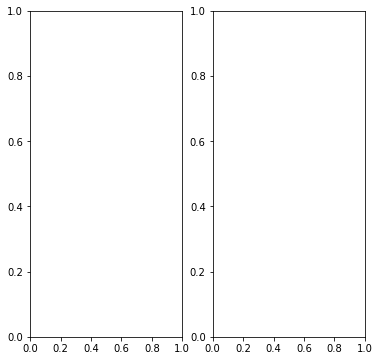

In [0]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(1, 2, figsize = (6, 6))
ax[0].plot(hist.history['loss'])
ax[0].plot(hist.history['val_loss'])
ax[1].plot(hist.history['IoU_metric'])
ax[1].plot(hist.history['val_IoU_metric'])

In [0]:
pred = model.predict(np.expand_dims(features[0], axis = 0))

In [0]:
print(lab[0])

[[[0.        0.609375  0.90625   0.125     0.1328125]
  [0.        0.609375  0.90625   0.125     0.1328125]
  [0.        0.609375  0.90625   0.125     0.1328125]
  [0.        0.609375  0.90625   0.125     0.1328125]]

 [[0.        0.609375  0.90625   0.125     0.1328125]
  [0.9       0.609375  0.90625   0.125     0.1328125]
  [0.        0.609375  0.90625   0.125     0.1328125]
  [0.        0.609375  0.90625   0.125     0.1328125]]

 [[0.        0.609375  0.90625   0.125     0.1328125]
  [0.        0.609375  0.90625   0.125     0.1328125]
  [0.        0.609375  0.90625   0.125     0.1328125]
  [0.        0.609375  0.90625   0.125     0.1328125]]

 [[0.        0.609375  0.90625   0.125     0.1328125]
  [0.        0.609375  0.90625   0.125     0.1328125]
  [0.        0.609375  0.90625   0.125     0.1328125]
  [0.        0.609375  0.90625   0.125     0.1328125]]]


In [0]:
print(pred[0])

[[[-0.00843343  0.4900724   0.4859988   0.17452477  0.13089915]
  [ 0.0120832   0.48969552  0.4874413   0.17408226  0.13078377]
  [ 0.00192466  0.48743698  0.4846936   0.17589118  0.12910393]
  [-0.00434398  0.48538885  0.48214206  0.17728846  0.12830186]]

 [[ 0.03117921  0.4923449   0.49005982  0.17298491  0.13267058]
  [ 0.09723926  0.4884332   0.48817205  0.17351153  0.13063663]
  [ 0.07781032  0.48691842  0.48595667  0.17428343  0.13012806]
  [ 0.03129216  0.48558336  0.48295414  0.17695212  0.12867057]]

 [[ 0.03527724  0.4928074   0.49055842  0.17270625  0.13297795]
  [ 0.10830535  0.4894581   0.48970285  0.17246664  0.1315873 ]
  [ 0.10386108  0.48957187  0.4898082   0.17230675  0.13171929]
  [ 0.03604706  0.48756242  0.48612422  0.17490578  0.12977666]]

 [[ 0.00542131  0.4902103   0.48794913  0.17455809  0.13120389]
  [ 0.04974428  0.48816642  0.48859996  0.17313951  0.13002278]
  [ 0.04693898  0.48802355  0.48832235  0.17329265  0.12998419]
  [ 0.01157925  0.48581082  0.4853

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


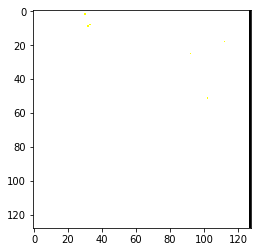

In [0]:
plt.imshow(features[0])

In [0]:
plot(features_test[0], int(4*19 + 0.30016974), int(5*19 + 0.35437733), int(19*9.951725), int(19*8.947725))

NameError: ignored

In [0]:
cv2.circle(features_test[0], (int(4*19 + 0.30016974), int(5*19 + 0.35437733)), 30, (255, 0, 0))

NameError: ignored

In [0]:
plt.imshow(features_test[0])

NameError: ignored

In [0]:
plot(features_test[0], z[1], z[2], z[3], z[4])

NameError: ignored

In [0]:
plt.imshow(features_test[0])

NameError: ignored

In [0]:
b = np.random.rand(2, 3, 5)

In [0]:
print(b)

In [0]:
print(b[..., 4])

In [0]:
print(b[..., 0])

In [0]:
print((b[0][1]))

In [0]:
print((b[0][1][1:]))

In [0]:
a = np.random.rand(6, 2, 3, 5)

In [0]:
q = a.shape
print(q)

In [0]:
print(a)

In [0]:
print(z)

In [0]:
b = 

In [0]:
sess = tf.Session()
print(a.eval(session = sess))

In [0]:

(xmi1, ymi1, xma1, yma1) = genNot1(1,2,3,4)
g = (1,2,3,4)
(xmi2, ymi2, xma2, yma2) = genNot1(g[0],g[1],g[2],g[3])
print(xmi1,ymi1,xma1,yma1)
print(xmi2,ymi2,xma2,yma2)

In [0]:
dx = min(xma1, xma2) - max(xmi1, xmi2)
dy = min(yma1, yma2) - max(ymi1, ymi2)
if (dx>=0) and (dy>=0):
  area_inter =  dx*dy
area_b1 = (abs(xma1 - xmi1)) * (abs(yma1 - ymi1))
area_b2 = (abs(xma2 - xmi2)) * (abs(yma2 - ymi2))
area_union = (area_b1 + area_b2 - area_inter)
iou = (area_inter)/float(area_union)

In [0]:
print(iou)

In [0]:
x = [1,2,3,4,5,6,7,8,9,10]
print(sum(x))

In [0]:
###################### TESTING mAP #######################################
Ithresh = 0.4
pr_ls = []
recall = []
final_dict = {}
cthresh = 0.3
for i in range(y_pred.shape[0]):  #For each image
  tp = 0
  fp = 0
  fn = 0
  N = 0
  for j in range(y_pred.shape[1]):
    for k in range(y_pred.shape[2]):
      if (y_pred[i][j][k][0] > cthresh) and (IoU(y_true[i][j][k], y_pred[i][j][k]) > Ithresh):
        N += 1  
      elif (y_pred[i][j][k][0] < cthresh) and (IoU(y_true[i][j][k], y_pred[i][j][k]) > Ithresh):
        fn += 1
  #We have N now, so:
  if N == 0:
    fp += 1
  elif N == 1:
    tp += 1
  elif N > 1:
    tp += 1
    fp += (N - 1)
  prec = tp/ float(tp + fp)
  recall = tp/ float(tp + fn)
  pr_ls.append([prec, recall])
  rec.append(recall)
rec_set = set(recall)
for recall in rec_set:
  pr = 0
  for i in range(len(pr_ls)):
    if (pr_ls[i][0] > pr) and (recall == pr_ls[i][1]):
      final_dict[recall] = pr
AP = sum(final_dict.values())/float(len(final_dict))